-- SMOTE Technique to be used after Train Test Split to balance the dataset. https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/

In [2]:
## Required Imports are done below:
import pandas as pd, numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None) #For print a long-sequence 
pd.set_option('display.max_colwidth', 500)
sns.set_palette("Paired")

In [3]:
##Defining a function for coloring NaN and Non-NaN values
def color_style(value):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for value 
    greater than 5% NaNs, and green for safer values 
    and black for anything otherwise.
    """
    if value>0:
        color= 'red'
    elif value==0:
        color='green'
    else:
        color='black'
    return 'color: %s' % color

In [4]:
##Defining a function for missing value percentage dataframe: null_prcnt_df
def null_prcnt_df(data):
    df= data.copy()
    missing = pd.DataFrame(100*df.isnull().sum()/len(df.index))
    missing.rename(columns={0:'Null_Percentage'}, inplace=True)
    missing = pd.DataFrame(missing.Null_Percentage).sort_values(by='Null_Percentage',ascending=False).style.applymap(color_style)
    return missing

In [5]:
##Function to display content in 'bold' within print statement
# from IPython.display import Markdown, display
# def printbold(string):   
#     return display(Markdown(string))

In [6]:
# ##Define a function for other evaluation metrics:
# def other_metrics_logistic_model(confusion):
    
#     TP = confusion[1,1] # true positive 
#     TN = confusion[0,0] # true negatives
#     FP = confusion[0,1] # false positives
#     FN = confusion[1,0] # false negatives
    
#     sensitivity= round((TP) / (TP+FN),4) #sensitivity of our logistic regression model
#     specificity= round((TN) / (TN+FP),4) #specificity  of our logistic regression model   
#     FPR= round((FP) / (TN+FP),4)        #False Positive Rate - predicting churn when customer does not have churned
#     positive_pred_val= round((TP) / (TP+FP),4)  #Positive predictive value
#     negative_pred_val= round((TN) / (TN+ FN),4) #Negative predictive value
#     misclass_rate = round((FN+FP)/(TP+TN+FP+FN),4)  #Misclassification rate
    
#     metric_list= ['Sensitivity', 'Specificity', 'False Positive Rate','Positive Predictive Value','Negative Predictive Value', 'Misclassification Rate']
#     metric_val = [sensitivity, specificity, FPR, positive_pred_val, negative_pred_val, misclass_rate]
#     evaluation_metrics_df=pd.DataFrame({'Evaluation Metrics':metric_list, 'Value': metric_val})
#     evaluation_metrics_df.set_index('Evaluation Metrics', inplace= True)
#     return evaluation_metrics_df

In [7]:
# ##Defining a function to plot confusion matrix

# from sklearn import metrics
# from sklearn.metrics import confusion_matrix

# def plot_confusion_matrix(cm):
#     """
#     This function prints and plots the confusion matrix.
#     """
#     classes=['Not Churned','Churned']
#     cmap=plt.cm.Reds
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title('Confusion Matrix', fontsize=14)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes)
#     plt.yticks(tick_marks, classes, rotation=90)
#     thresh = cm.max() / 2.
#     for i in range (cm.shape[0]):
#         for j in range (cm.shape[1]):
#             plt.text(j, i, cm[i, j],horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")
#     plt.tight_layout()
#     plt.ylabel('True label', fontsize= 10)
#     plt.xlabel('Predicted label', fontsize=10)


# def print_model_metrics(y_test,y_pred,model_name):
#     print(model_name+" Model Stats Scores Summary : ")
#     cp = confusion_matrix(y_test,y_pred)
#     plt.figure()
#     plot_confusion_matrix(cp)
#     plt.show()

In [8]:
data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [9]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belongs to
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile to mobile
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [10]:
data.head(5)

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,Na

In [11]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        69999 non-null  int64  
 1    circle_id                 69999 non-null  int64  
 2    loc_og_t2o_mou            69297 non-null  float64
 3    std_og_t2o_mou            69297 non-null  float64
 4    loc_ic_t2o_mou            69297 non-null  float64
 5    last_date_of_month_6      69999 non-null  object 
 6    last_date_of_month_7      69600 non-null  object 
 7    last_date_of_month_8      69266 non-null  object 
 8    arpu_6                    69999 non-null  float64
 9    arpu_7                    69999 non-null  float64
 10   arpu_8                    69999 non-null  float64
 11   onnet_mou_6               67231 non-null  float64
 12   onnet_mou_7               67312 non-null  float64
 13   onnet_mou_8               66296 non-null  fl

In [12]:
data = data.drop_duplicates()

In [13]:
rech_cols = [i for i in data.columns if re.search("rech_amt|rech_data",i)]
rech_cols

['total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8']

In [14]:
# Checking for null values in the columns related to recharge:
recharge_df = pd.DataFrame(data[rech_cols])
null_prcnt_df(recharge_df)

,Null_Percentage
total_rech_data_6,74.902499
av_rech_amt_data_6,74.902499
date_of_last_rech_data_6,74.902499
max_rech_data_6,74.902499
total_rech_data_7,74.478207
av_rech_amt_data_7,74.478207
max_rech_data_7,74.478207
date_of_last_rech_data_7,74.478207
max_rech_data_8,73.689624
total_rech_data_8,73.689624


In [15]:
recharge_df.describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8
count,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000
mean,328.139788,322.376363,323.846355,104.569265,104.137573,107.540351,2.467612,2.679989,2.652441,126.500000,126.402071,125.374925,192.831096,201.455940,196.815792
std,404.211068,411.070120,426.181405,121.407701,120.782543,124.396750,2.794610,3.073472,3.101265,109.352573,109.459266,109.648799,190.623115,198.346141,192.280532
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,110.000000,100.000000,90.000000,30.000000,30.000000,30.000000,1.000000,1.000000,1.000000,25.000000,25.000000,25.000000,82.000000,92.000000,84.000000
50%,229.000000,220.000000,225.000000,110.000000,110.000000,98.000000,1.000000,2.000000,1.000000,145.000000,145.000000,145.000000,154.000000,154.000000,154.000000
75%,438.000000,430.000000,436.000000,120.000000,128.000000,144.000000,3.000000,3.000000,3.000000,177.000000,177.000000,179.000000,252.000000,252.000000,252.000000
max,35190.000000,40335.000000,45320.000000,4010.000000,3299.000000,4449.000000,61.000000,54.000000,60.000000,1555.000000,1555.000000,1555.000000,5920.000000,4365.000000,4076.000000


In [16]:
# Columns having minimum value as 1, can be imputed to 0, indicating no recharge was done. 
rech_cols_min = ["total_rech_data_6", "total_rech_data_7", "total_rech_data_8",
        "max_rech_data_6", "max_rech_data_7", "max_rech_data_8",
        "av_rech_amt_data_6", "av_rech_amt_data_7", "av_rech_amt_data_8"]

In [17]:
imp = SimpleImputer(strategy='constant', fill_value=0)
data[rech_cols_min] = imp.fit_transform(data[rech_cols_min])

In [18]:
data["tot_rech_data_amt_6"] = data["av_rech_amt_data_6"] * data["total_rech_data_6"]
data["tot_rech_data_amt_7"] = data["av_rech_amt_data_7"] * data["total_rech_data_7"]
data["tot_rech_data_amt_8"] = data["av_rech_amt_data_8"] * data["total_rech_data_8"]

# average recharge data amount for 6th and 7th month
data["av_rech_data_amt_6_7"] = ((data["tot_rech_data_amt_6"] + data["total_rech_amt_6"])
                                + (data["tot_rech_data_amt_7"]+ data["total_rech_amt_7"]))/2


In [19]:
##Creating a function for boxplots for features belonging to months (6), (7) and (8) respectively with churn and no churn hue.
##(0: Not Churned (Retention), 1: Churned)

def plot_boxplots_6_7_8(feature):  ## Note: Showfliers: False (Suppresses the effect of outliers on the graphs.)
    plt.figure(figsize=(24, 10), dpi=250)
    df = data.copy()
    
    # Color palette
    colors = {"Not Churned": "#32CD32", "Churned": "#FF4500"}

    # Plot for feature_6
    plt.subplot(1, 3, 1)
    sns.boxplot(
        data=df, y=feature + "_6", x="churn_probability", showfliers=False,
        palette=[colors["Not Churned"], colors["Churned"]]
    )
    plt.title(f"\nBoxplot: '{feature}_6'\n", fontsize=22, fontweight='bold')
    plt.ylabel(feature + "_6", fontsize=20, fontstyle='italic')
    plt.xlabel("Churn", fontsize=22, fontstyle='italic')
    plt.xticks([0, 1], ['Not Churned\n(Retention)', 'Churned'], fontsize=18)
    plt.yticks(fontsize=16)
    
    # Plot for feature_7
    plt.subplot(1, 3, 2)
    sns.boxplot(
        data=df, y=feature + "_7", x="churn_probability", showfliers=False,
        palette=[colors["Not Churned"], colors["Churned"]]
    )
    plt.title(f"\nBoxplot: '{feature}_7'\n", fontsize=22, fontweight='bold')
    plt.ylabel(feature + "_7", fontsize=20, fontstyle='italic')
    plt.xlabel("Churn", fontsize=22, fontstyle='italic')
    plt.xticks([0, 1], ['Not Churned\n(Retention)', 'Churned'], fontsize=18)
    plt.yticks(fontsize=16)
    
    # Plot for feature_8
    plt.subplot(1, 3, 3)
    sns.boxplot(
        data=df, y=feature + "_8", x="churn_probability", showfliers=False,
        palette=[colors["Not Churned"], colors["Churned"]]
    )
    plt.title(f"\nBoxplot: '{feature}_8'\n", fontsize=22, fontweight='bold')
    plt.ylabel(feature + "_8", fontsize=20, fontstyle='italic')
    plt.xlabel("Churn", fontsize=22, fontstyle='italic')
    plt.xticks([0, 1], ['Not Churned\n(Retention)', 'Churned'], fontsize=18)
    plt.yticks(fontsize=16)
    
    # Adding a custom legend
    plt.figlegend(
        labels=["Not Churned (Retention)", "Churned"],
        loc="upper center", ncol=2, fontsize=18,
        frameon=True, framealpha=1, shadow=True, borderpad=1,
        facecolor='white'
    )
    
    plt.tight_layout()
    plt.show()

In [20]:
# Total Outgoing

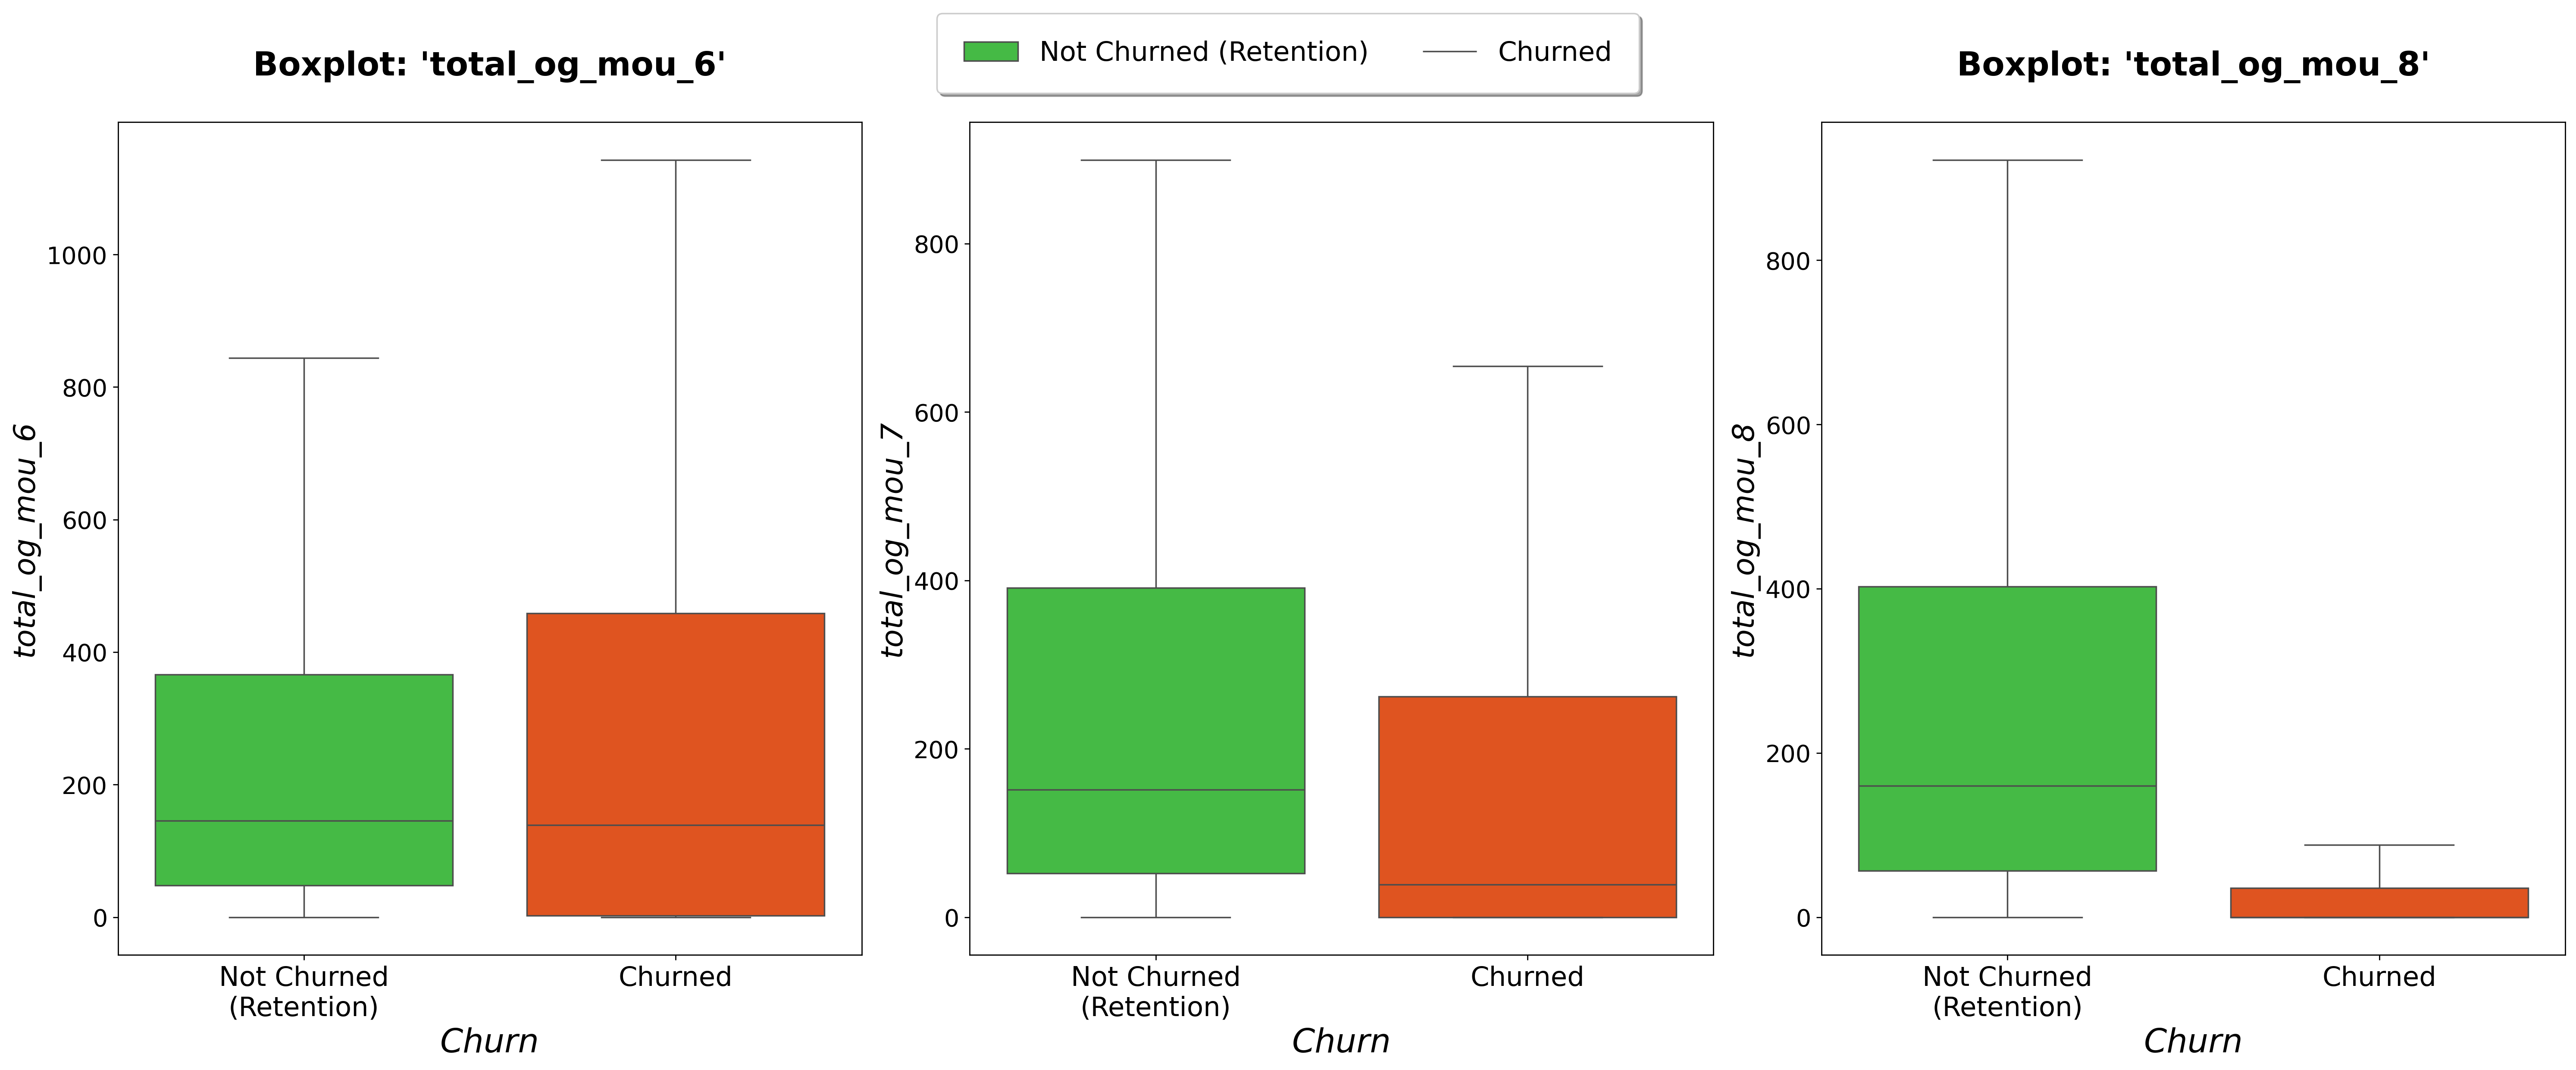

In [21]:
plot_boxplots_6_7_8("total_og_mou")


#### General Observations

Outliers: There are some outliers present in the data, especially for the churned customers in total_og_mou_6. These outliers suggest that some churned customers have significantly higher outgoing minutes compared to the majority.
Churn vs. Non-Churn

Median: The median outgoing minutes for churned customers are generally lower than those for non-churned customers across all three months. This suggests that customers who churn tend to have lower outgoing minutes.
Distribution: The distribution of outgoing minutes for churned customers is more spread out (higher variability) compared to non-churned customers, particularly in total_og_mou_6. This indicates that churned customers exhibit a wider range of outgoing minutes.
Month-to-Month Comparison

Total_og_mou_6: The median outgoing minutes for both churned and non-churned customers are highest in this month.
Total_og_mou_7: There's a slight decrease in the median outgoing minutes for both groups compared to total_og_mou_6.
Total_og_mou_8: The median outgoing minutes continue to decrease for both groups compared to the previous months.
Possible Interpretations

Lower Usage as a Churn Indicator: The lower outgoing minutes for churned customers might suggest that decreasing usage is a potential indicator of churn.
Usage Patterns and Churn: The spread in outgoing minutes for churned customers might indicate that there are different usage patterns among customers who churn. Some might have very low usage, while others might have high usage but still churn due to other factors.

In [23]:
# Total Incoming

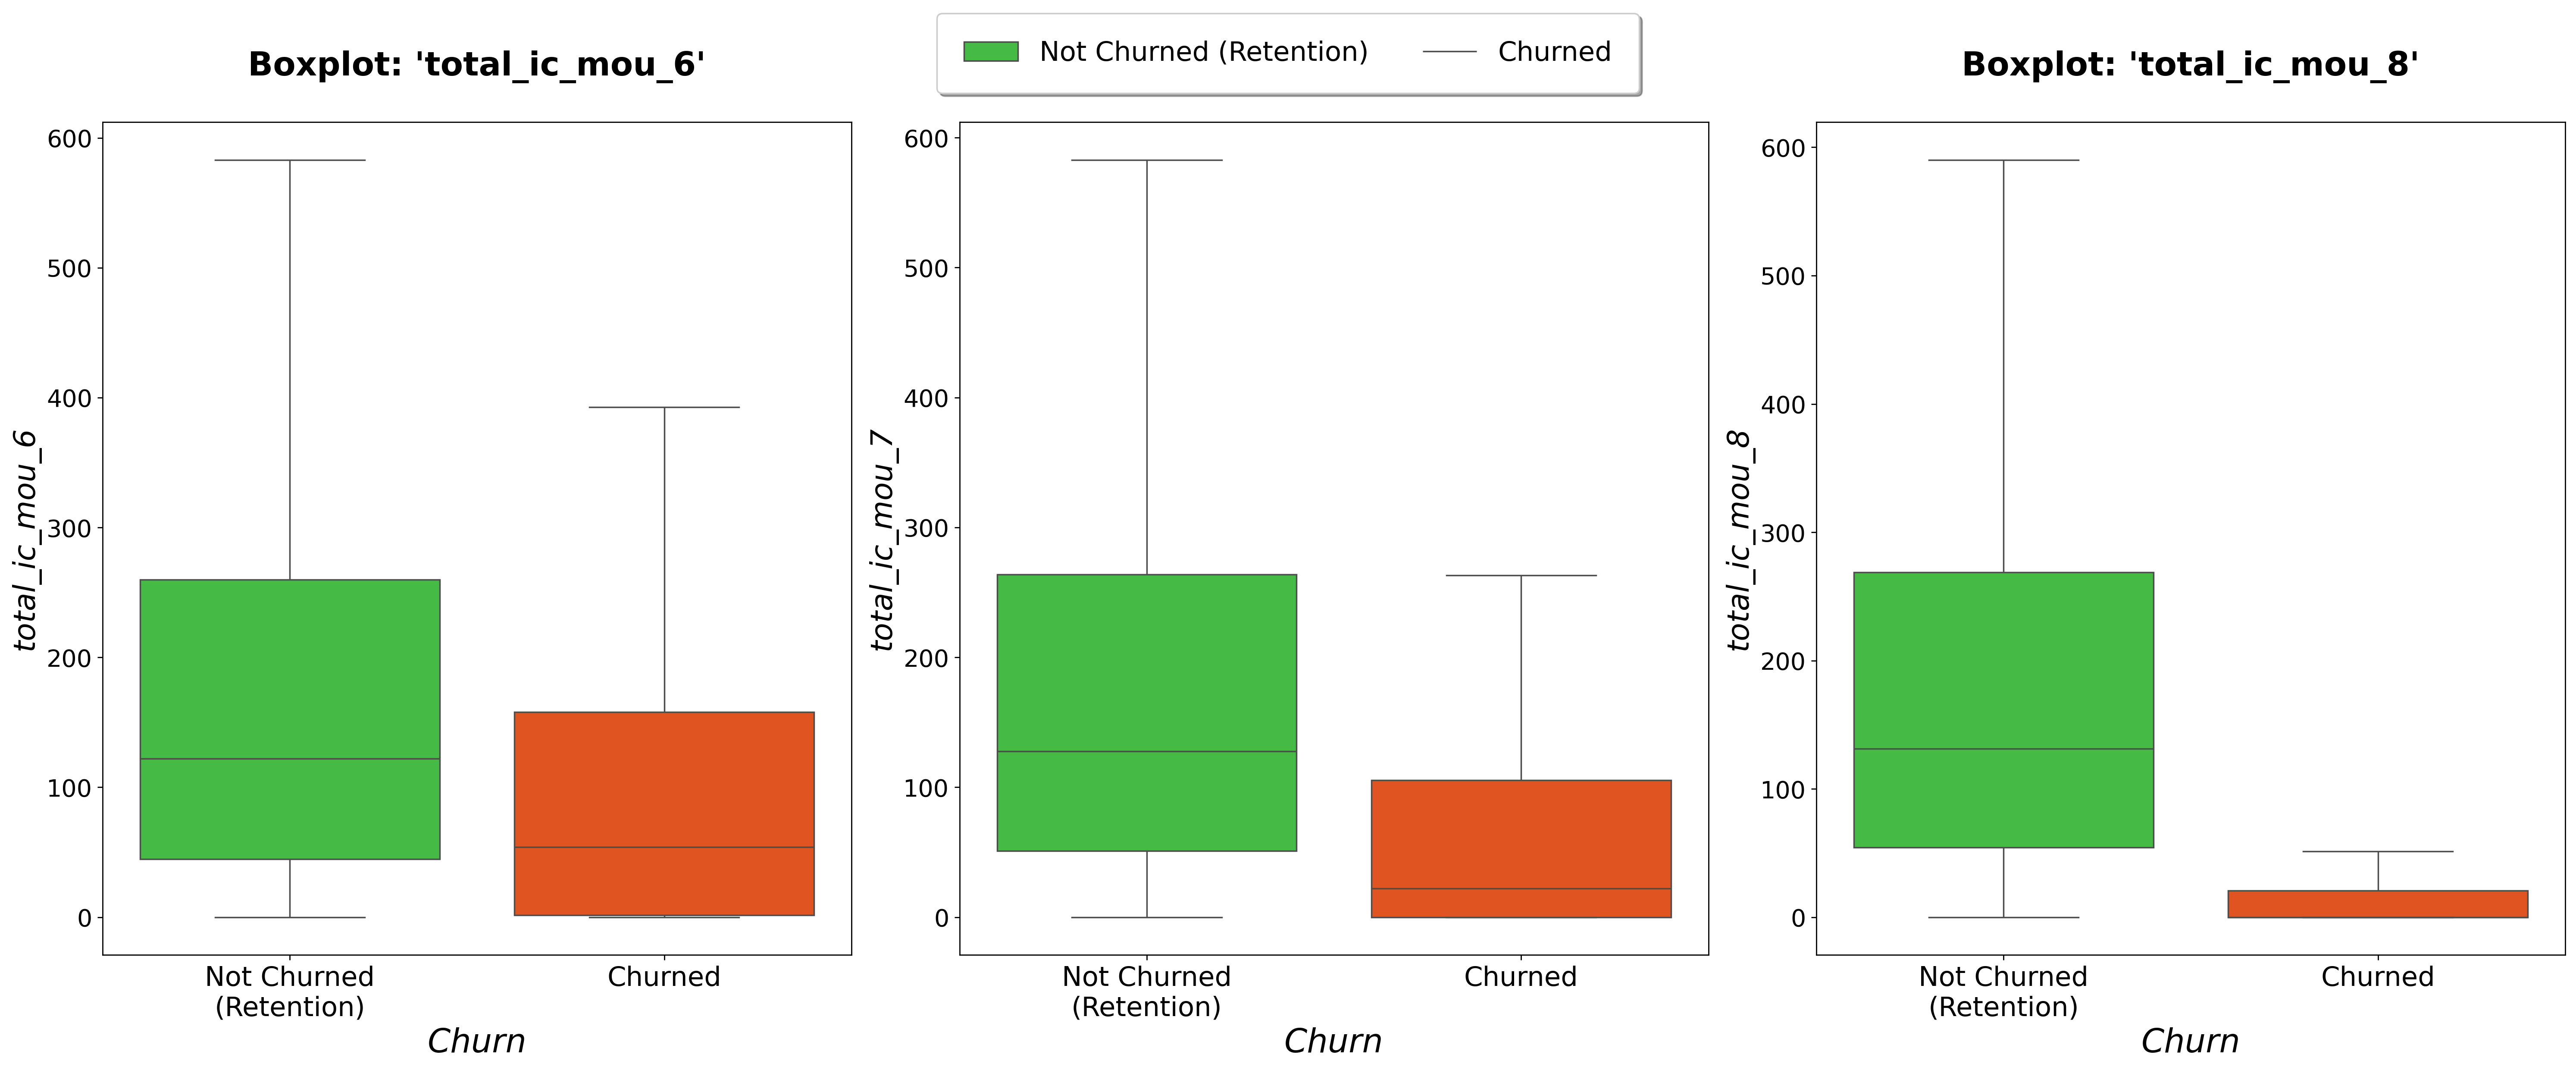

In [24]:
plot_boxplots_6_7_8("total_ic_mou")

#### General Observations

Outliers: There are some outliers present in the data, especially for the churned customers in total_ic_mou_6. These outliers suggest that some churned customers have significantly higher incoming minutes compared to the majority.
Churn vs. Non-Churn

Median: The median incoming minutes for churned customers are generally lower than those for non-churned customers across all three months. This suggests that customers who churn tend to have lower incoming minutes.
Distribution: The distribution of incoming minutes for churned customers is more spread out (higher variability) compared to non-churned customers, particularly in total_ic_mou_6. This indicates that churned customers exhibit a wider range of incoming minutes.
Month-to-Month Comparison

Total_ic_mou_6: The median incoming minutes for both churned and non-churned customers are highest in this month.
Total_ic_mou_7: There's a slight decrease in the median incoming minutes for both groups compared to total_ic_mou_6.
Total_ic_mou_8: The median incoming minutes continue to decrease for both groups compared to the previous months.
Possible Interpretations

Lower Usage as a Churn Indicator: The lower incoming minutes for churned customers might suggest that decreasing usage is a potential indicator of churn.
Usage Patterns and Churn: The spread in incoming minutes for churned customers might indicate that there are different usage patterns among customers who churn. Some might have very low usage, while others might have high usage but still churn due to other factors.



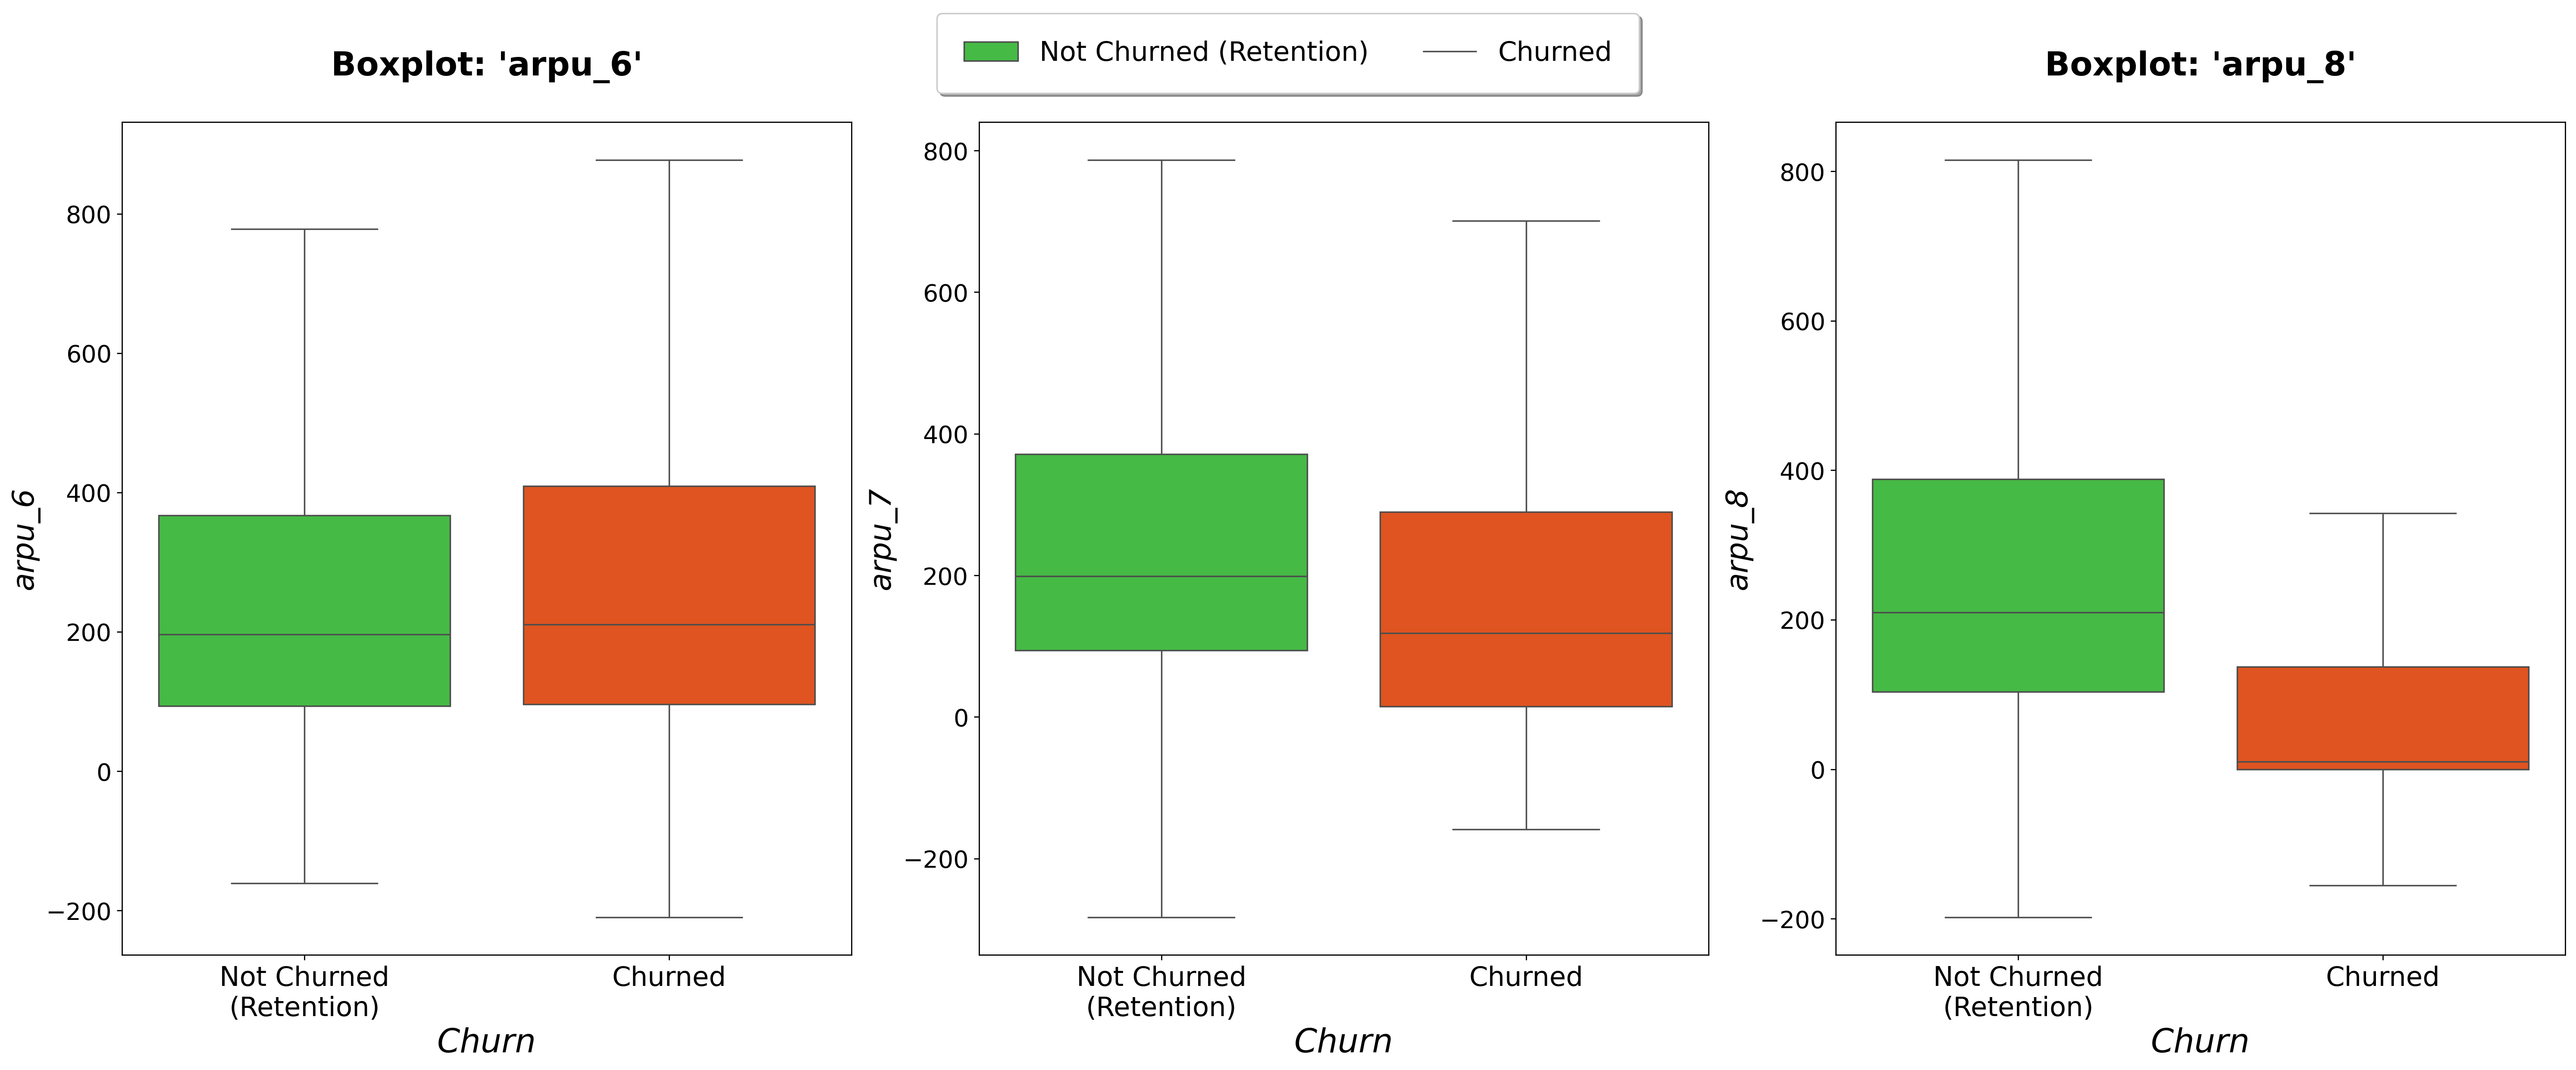

In [26]:
plot_boxplots_6_7_8("arpu")

### General Observations:

Outliers: There are some outliers present in the data, especially for churned customers in arpu_6. This indicates that a few churned customers had significantly higher ARPU compared to the majority.
Churn vs. Non-Churn

Median: The median ARPU for churned customers is generally lower than that for non-churned customers across all three months. This suggests that customers who churn tend to have lower revenue generation.
Distribution: The distribution of ARPU for churned customers is more spread out (higher variability) compared to non-churned customers, particularly in arpu_6. This indicates that churned customers exhibit a wider range of ARPU values.
Month-to-Month Comparison

arpu_6: The median ARPU for both churned and non-churned customers is highest in this month.
arpu_7: There's a slight decrease in the median ARPU for both groups compared to arpu_6.
arpu_8: The median ARPU continues to decrease for both groups compared to the previous months.
Possible Interpretations

Revenue Decline as Churn Indicator: The lower ARPU for churned customers might suggest that decreasing revenue generation is a potential indicator of churn.
Revenue Patterns and Churn: The spread in ARPU for churned customers might indicate that there are different revenue patterns among customers who churn. Some might have very low revenue, while others might have higher revenue but still churn due to other factors.



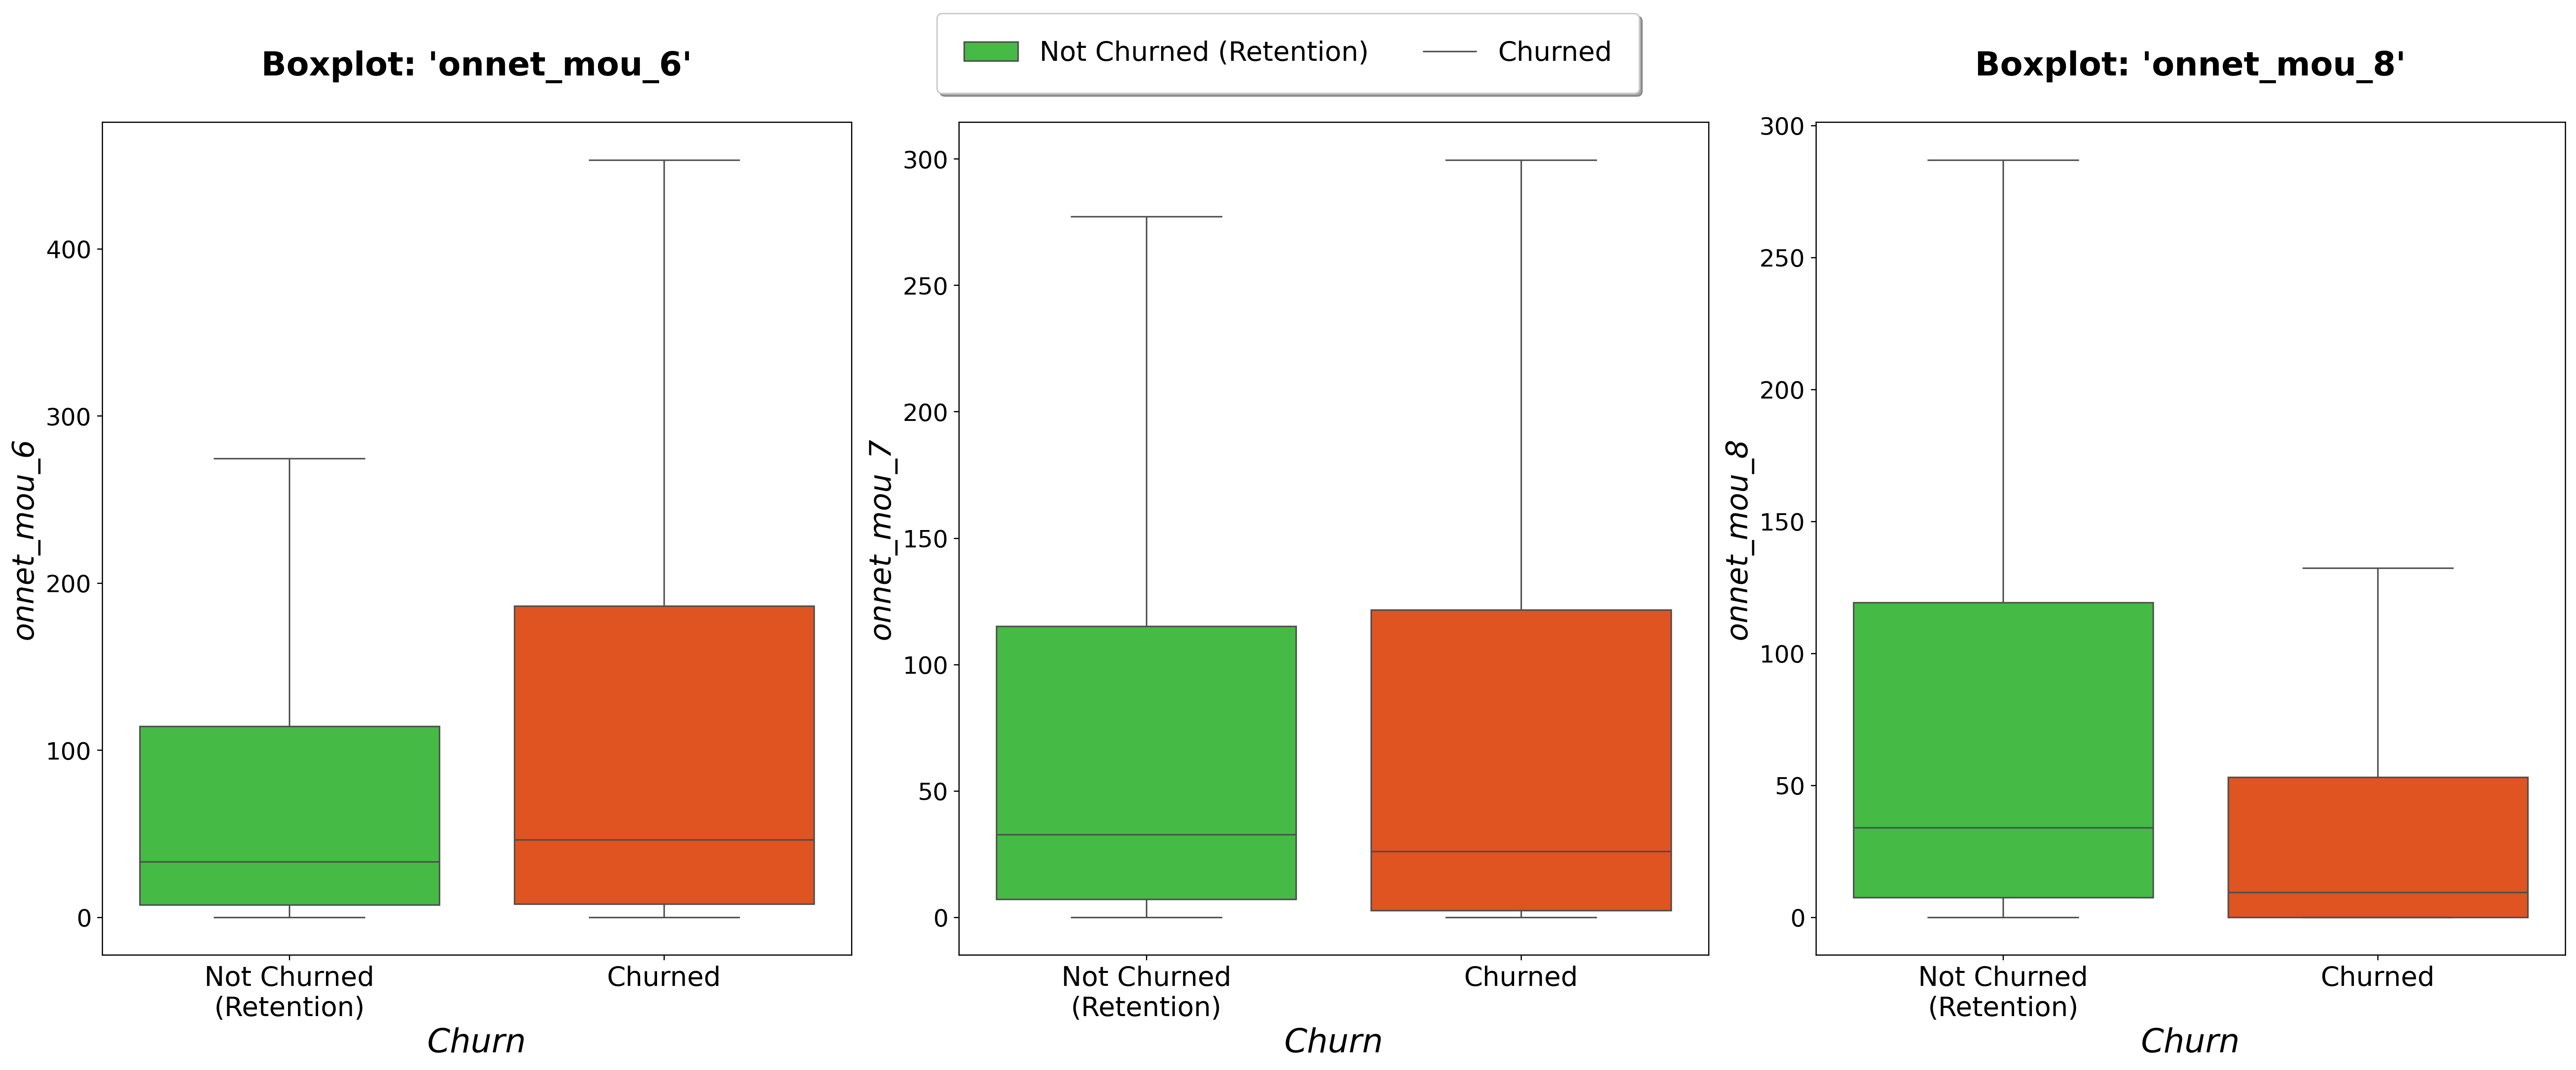

In [28]:
plot_boxplots_6_7_8("onnet_mou")

#### General Observations

Outliers: There are some outliers present in the data, especially for the churned customers in onnet_mou_6. These outliers suggest that some churned customers have significantly higher on-net minutes compared to the majority.
Churn vs. Non-Churn

Median: The median on-net minutes for churned customers are generally lower than those for non-churned customers across all three months. This suggests that customers who churn tend to have lower on-net minutes.
Distribution: The distribution of on-net minutes for churned customers is more spread out (higher variability) compared to non-churned customers, particularly in onnet_mou_6. This indicates that churned customers exhibit a wider range of on-net minutes.
Month-to-Month Comparison

onnet_mou_6: The median on-net minutes for both churned and non-churned customers are highest in this month.
onnet_mou_7: There's a slight decrease in the median on-net minutes for both groups compared to onnet_mou_6.
onnet_mou_8: The median on-net minutes continue to decrease for both groups compared to the previous months.
Possible Interpretations

Lower Usage as a Churn Indicator: The lower on-net minutes for churned customers might suggest that decreasing usage is a potential indicator of churn.
Usage Patterns and Churn: The spread in on-net minutes for churned customers might indicate that there are different usage patterns among customers who churn. Some might have very low usage, while others might have high usage but still churn due to other factors.



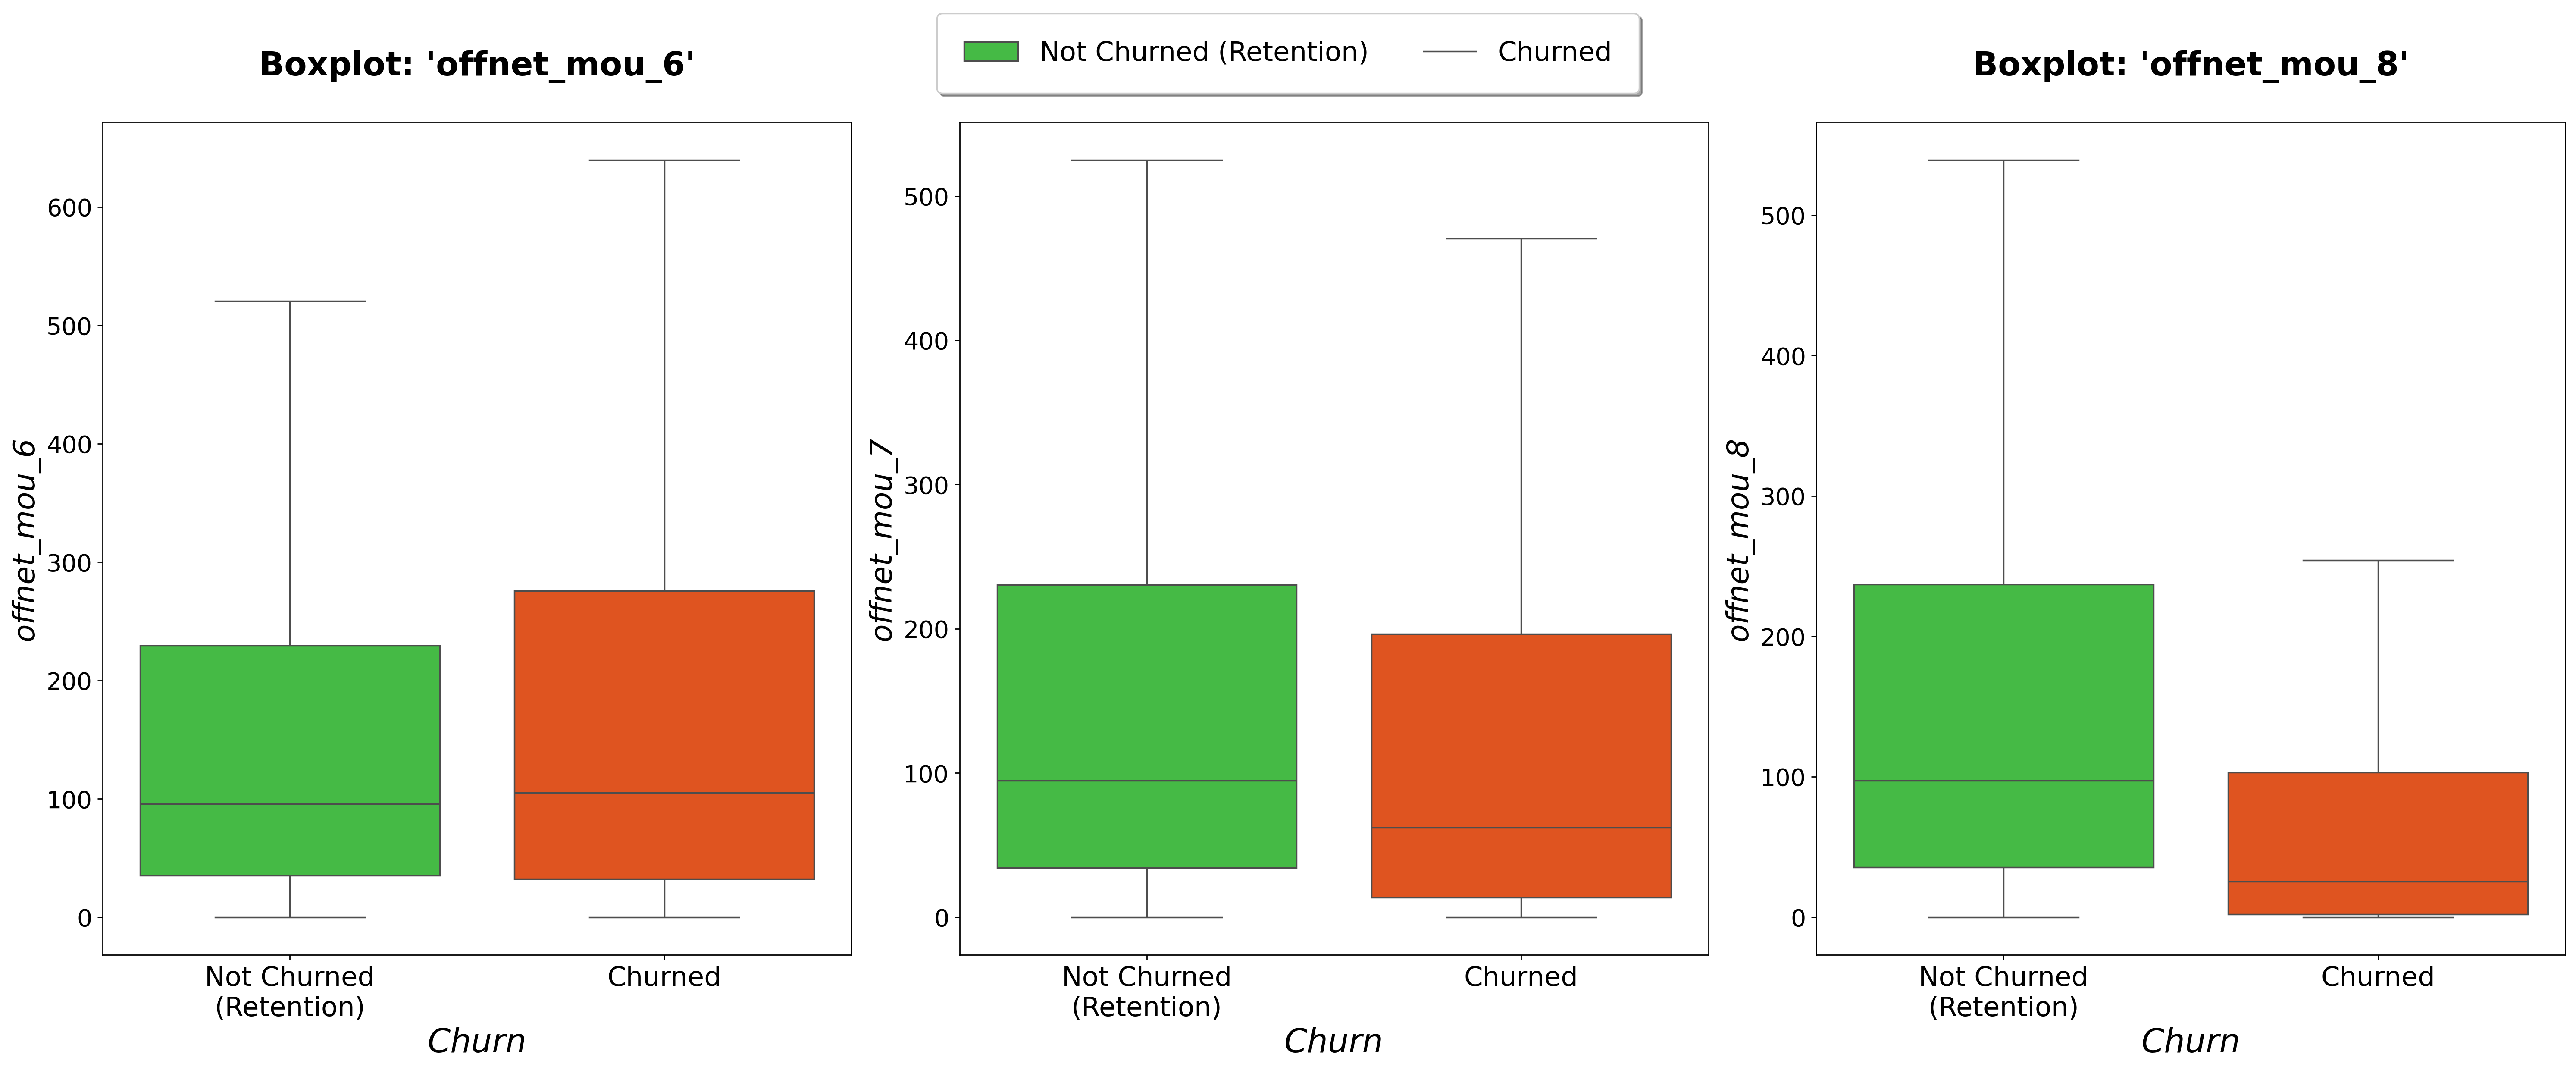

In [30]:
plot_boxplots_6_7_8("offnet_mou")

#### General Observations

Outliers: There are some outliers present in the data, especially for the churned customers in offnet_mou_6. These outliers suggest that some churned customers have significantly higher off-net minutes compared to the majority.
Churn vs. Non-Churn

Median: The median off-net minutes for churned customers are generally lower than those for non-churned customers across all three months. This suggests that customers who churn tend to have lower off-net minutes.
Distribution: The distribution of off-net minutes for churned customers is more spread out (higher variability) compared to non-churned customers, particularly in offnet_mou_6. This indicates that churned customers exhibit a wider range of off-net minutes.
Month-to-Month Comparison

offnet_mou_6: The median off-net minutes for both churned and non-churned customers are highest in this month.
offnet_mou_7: There's a slight decrease in the median off-net minutes for both groups compared to offnet_mou_6.
offnet_mou_8: The median off-net minutes continue to decrease for both groups compared to the previous months.
Possible Interpretations

Lower Usage as a Churn Indicator: The lower off-net minutes for churned customers might suggest that decreasing usage is a potential indicator of churn.
Usage Patterns and Churn: The spread in off-net minutes for churned customers might indicate that there are different usage patterns among customers who churn. Some might have very low usage, while others might have high usage but still churn due to other factors.

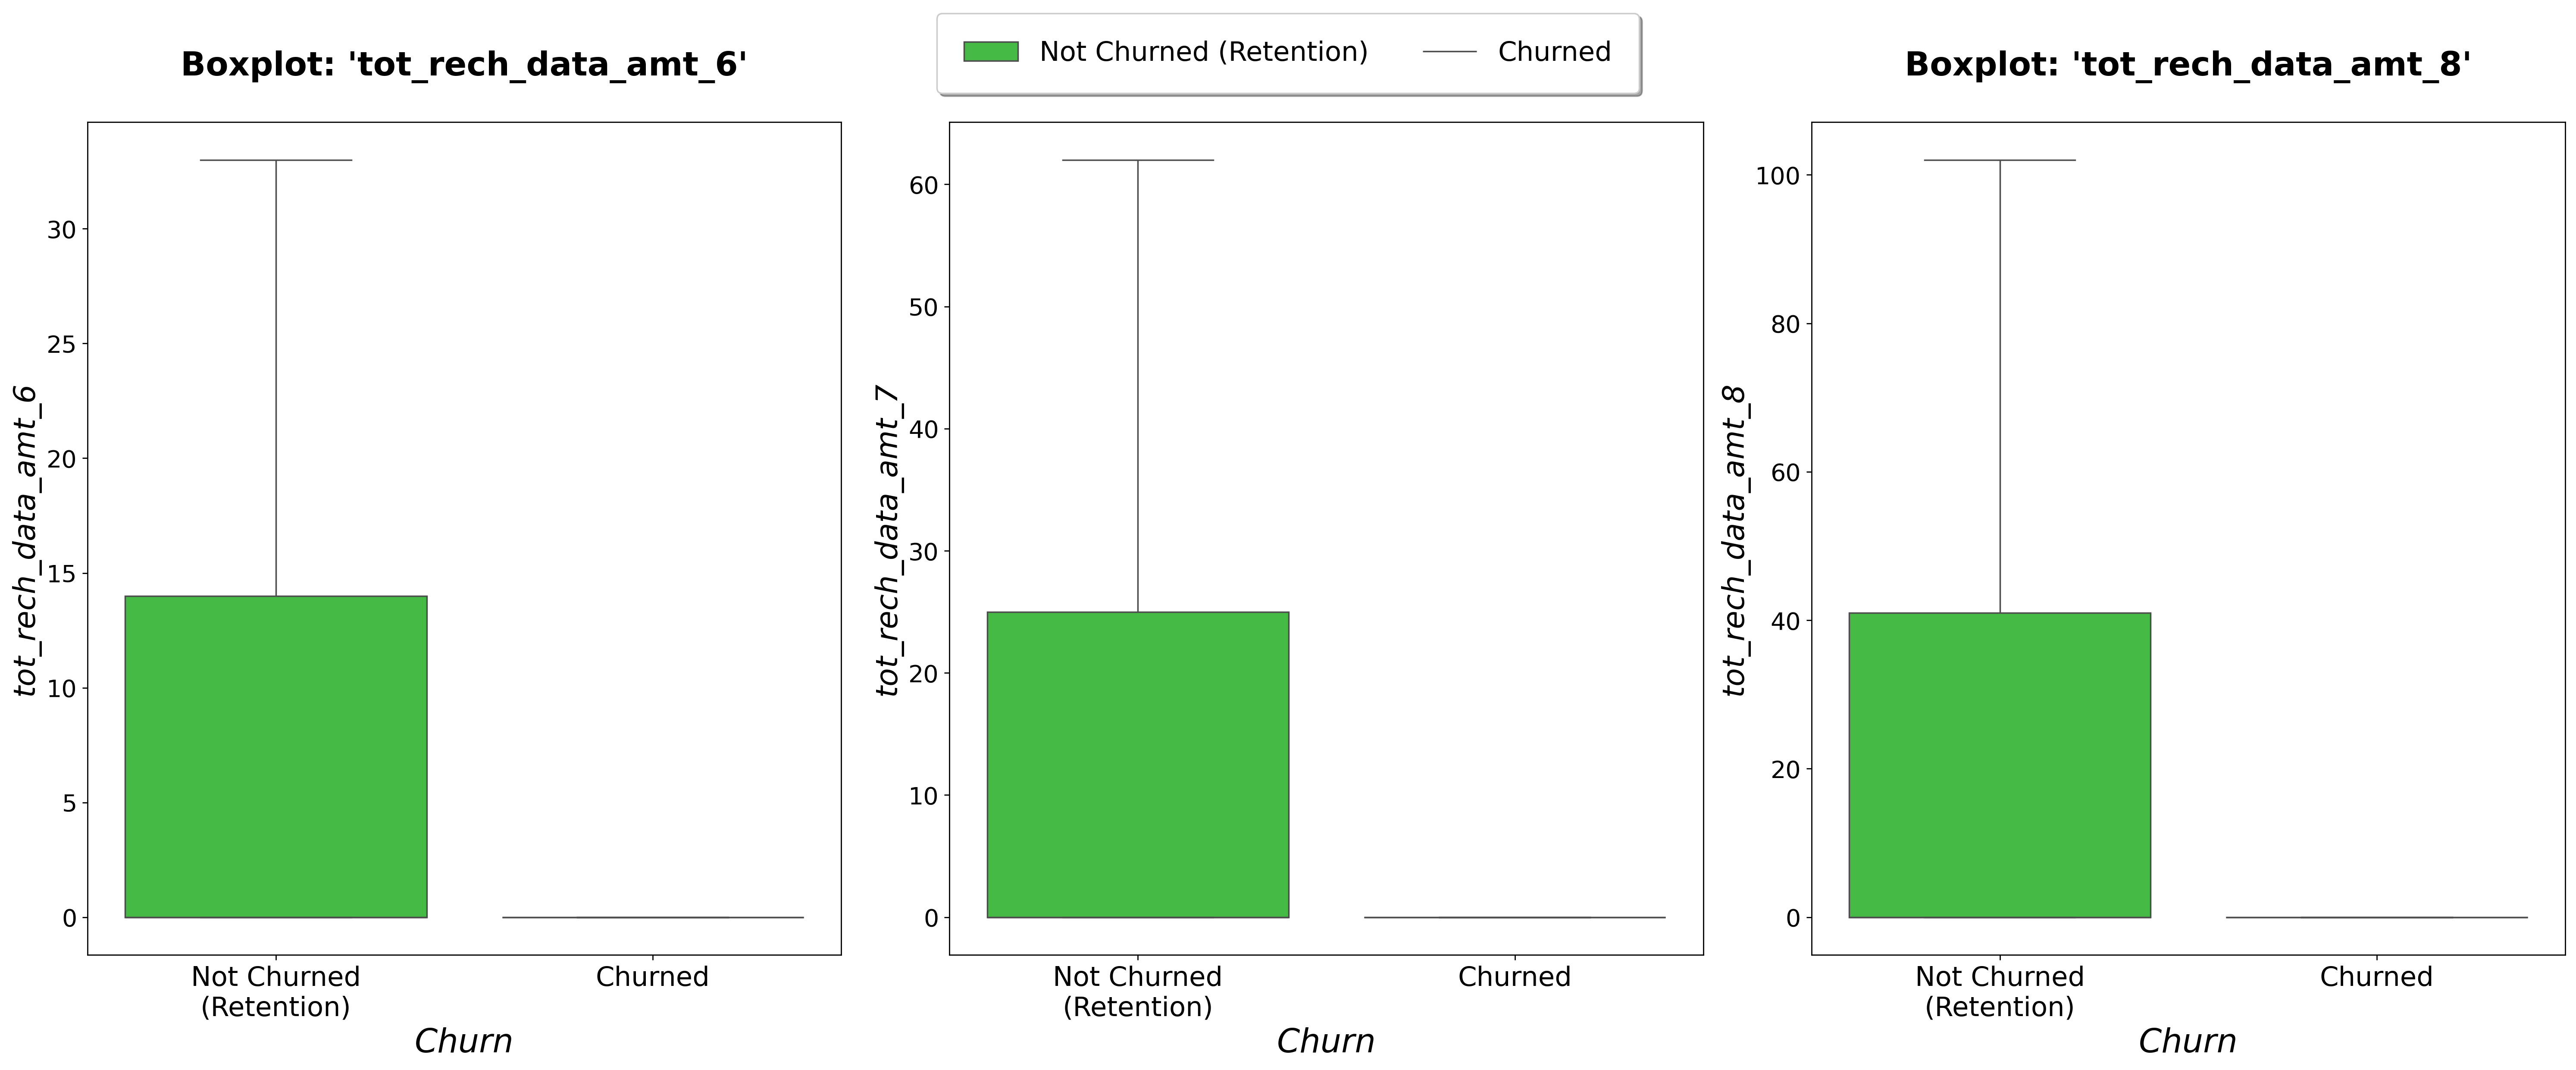

In [32]:
plot_boxplots_6_7_8("tot_rech_data_amt")

#### General Observations

Outliers: There are no outliers present in the data for any of the months.
Churn vs. Non-Churn

Median: The median total data recharge amount for churned customers is generally lower than that for non-churned customers across all three months. This suggests that customers who churn tend to have lower data recharge amounts.
Distribution: The distribution of total data recharge amounts for churned customers is more spread out (higher variability) compared to non-churned customers, particularly in tot_rech_data_amt_6. This indicates that churned customers exhibit a wider range of data recharge amounts.
Month-to-Month Comparison

tot_rech_data_amt_6: The median total data recharge amount for both churned and non-churned customers is highest in this month.
tot_rech_data_amt_7: There's a slight decrease in the median total data recharge amount for both groups compared to tot_rech_data_amt_6.
tot_rech_data_amt_8: The median total data recharge amount continues to decrease for both groups compared to the previous months.



In [34]:
def plot_countplots_6_7_8(feature):
    # Set the color palette using "hls"
    palette = sns.color_palette("hls", 8)

    plt.figure(figsize=(24, 10), dpi=250)
    df = data.copy()

    # Plot for feature_6
    plt.subplot(1, 3, 1)
    ax_11 = sns.countplot(data=df, x=feature + "_6", hue="churn_probability", palette=palette[:2])
    plt.title(f"\nCountplot: '{feature}_6'\n", fontsize=22, fontweight='bold')
    plt.ylabel(feature + "_6", fontsize=16, fontstyle='italic')
    plt.xlabel("Churn", fontsize=22, fontstyle='italic')
    plt.yticks(fontsize=16)

    # Customize legend
    T1 = ax_11.legend(loc='center', bbox_to_anchor=(0.5, 0.94), fancybox=True, framealpha=1, shadow=True, borderpad=1)
    T1.get_texts()[0].set_text('Not Churned (Retention)')
    T1.get_texts()[1].set_text('Churned')

    # Plot for feature_7
    plt.subplot(1, 3, 2)
    ax_22 = sns.countplot(data=df, x=feature + "_7", hue="churn_probability", palette=palette[:2])
    plt.title(f"\nCountplot: '{feature}_7'\n", fontsize=22, fontweight='bold')
    plt.ylabel(feature + "_7", fontsize=16, fontstyle='italic')
    plt.xlabel("Churn", fontsize=22, fontstyle='italic')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # Customize legend
    T2 = ax_22.legend(loc='center', bbox_to_anchor=(0.5, 0.94), fancybox=True, framealpha=1, shadow=True, borderpad=1)
    T2.get_texts()[0].set_text('Not Churned (Retention)')
    T2.get_texts()[1].set_text('Churned')

    # Plot for feature_8
    plt.subplot(1, 3, 3)
    ax_33 = sns.countplot(data=df, x=feature + "_8", hue="churn_probability", palette=palette[:2])
    plt.title(f"\nCountplot: '{feature}_8'\n", fontsize=22, fontweight='bold')
    plt.ylabel(feature + "_8", fontsize=16, fontstyle='italic')
    plt.xlabel("Churn", fontsize=22, fontstyle='italic')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # Customize legend
    T3 = ax_33.legend(loc='center', bbox_to_anchor=(0.5, 0.94), fancybox=True, framealpha=1, shadow=True, borderpad=1)
    T3.get_texts()[0].set_text('Not Churned (Retention)')
    T3.get_texts()[1].set_text('Churned')

    plt.tight_layout()
    plt.show()

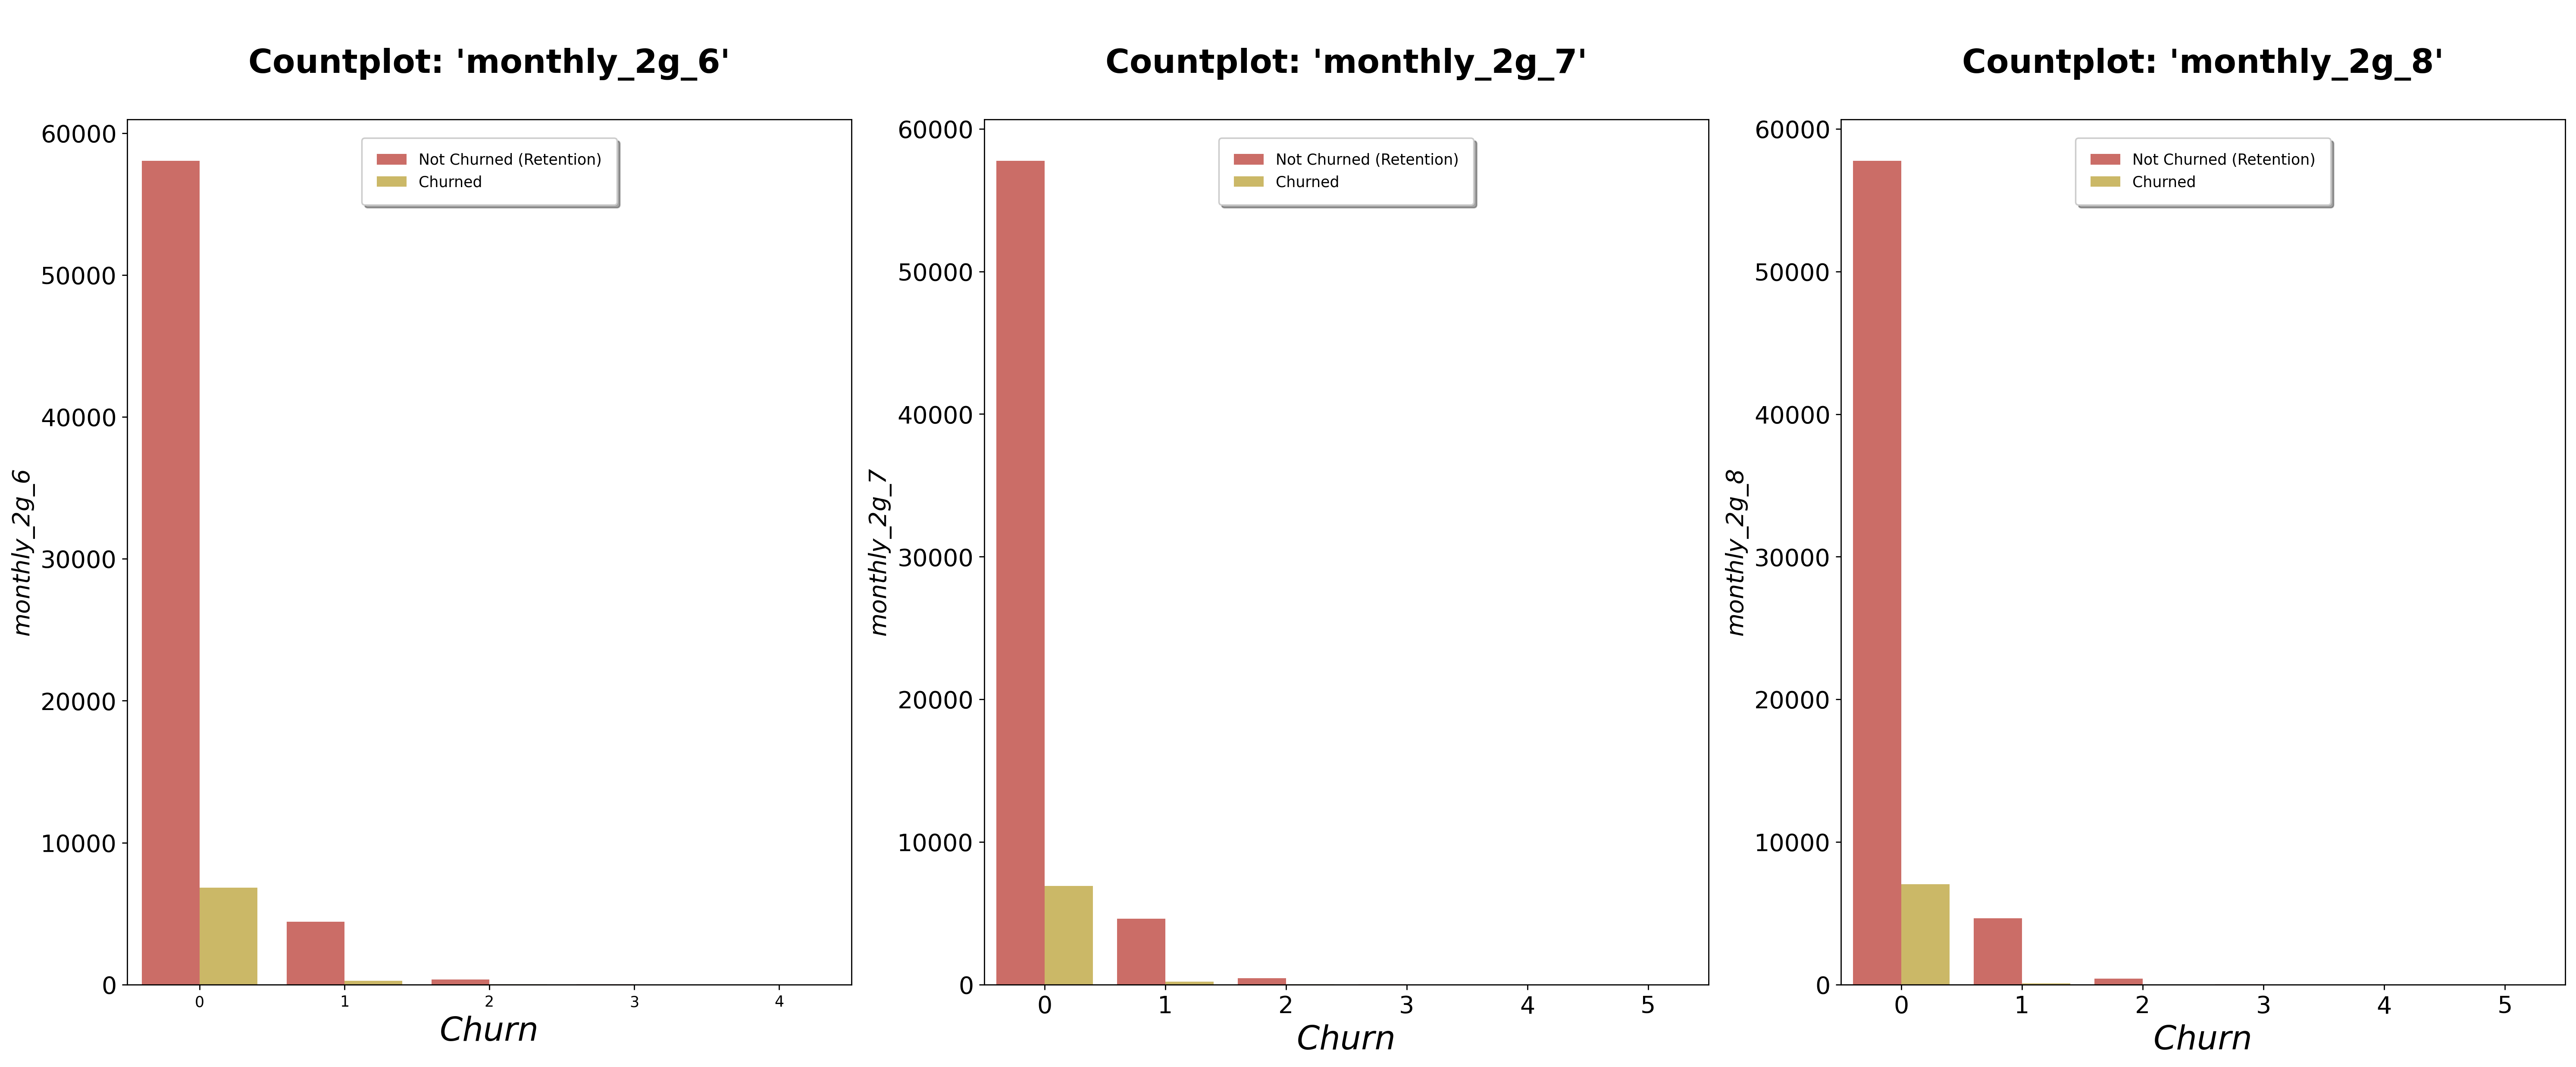

In [35]:
plot_countplots_6_7_8("monthly_2g")

#### General Observations

Distribution: The distribution of monthly_2g usage is heavily skewed towards the lower end for both churned and non-churned customers in all three months. This suggests that a significant portion of customers have low or no 2G usage.
Churn vs. Non-Churn

Usage: The majority of customers in all three months, regardless of churn status, fall into the lowest usage categories (0-2).
Churn Proportion: The proportion of churned customers within each usage category is generally lower than the proportion of non-churned customers. This suggests that customers with higher monthly_2g usage might be less likely to churn.
Month-to-Month Comparison

Usage Patterns: The overall usage patterns seem to be relatively consistent across the three months.
Churn Proportion: The proportion of churned customers within each usage category appears to remain fairly stable across the months.
Possible Interpretations

Usage and Churn: While the relationship might not be straightforward, higher monthly_2g usage could be associated with a lower churn risk.

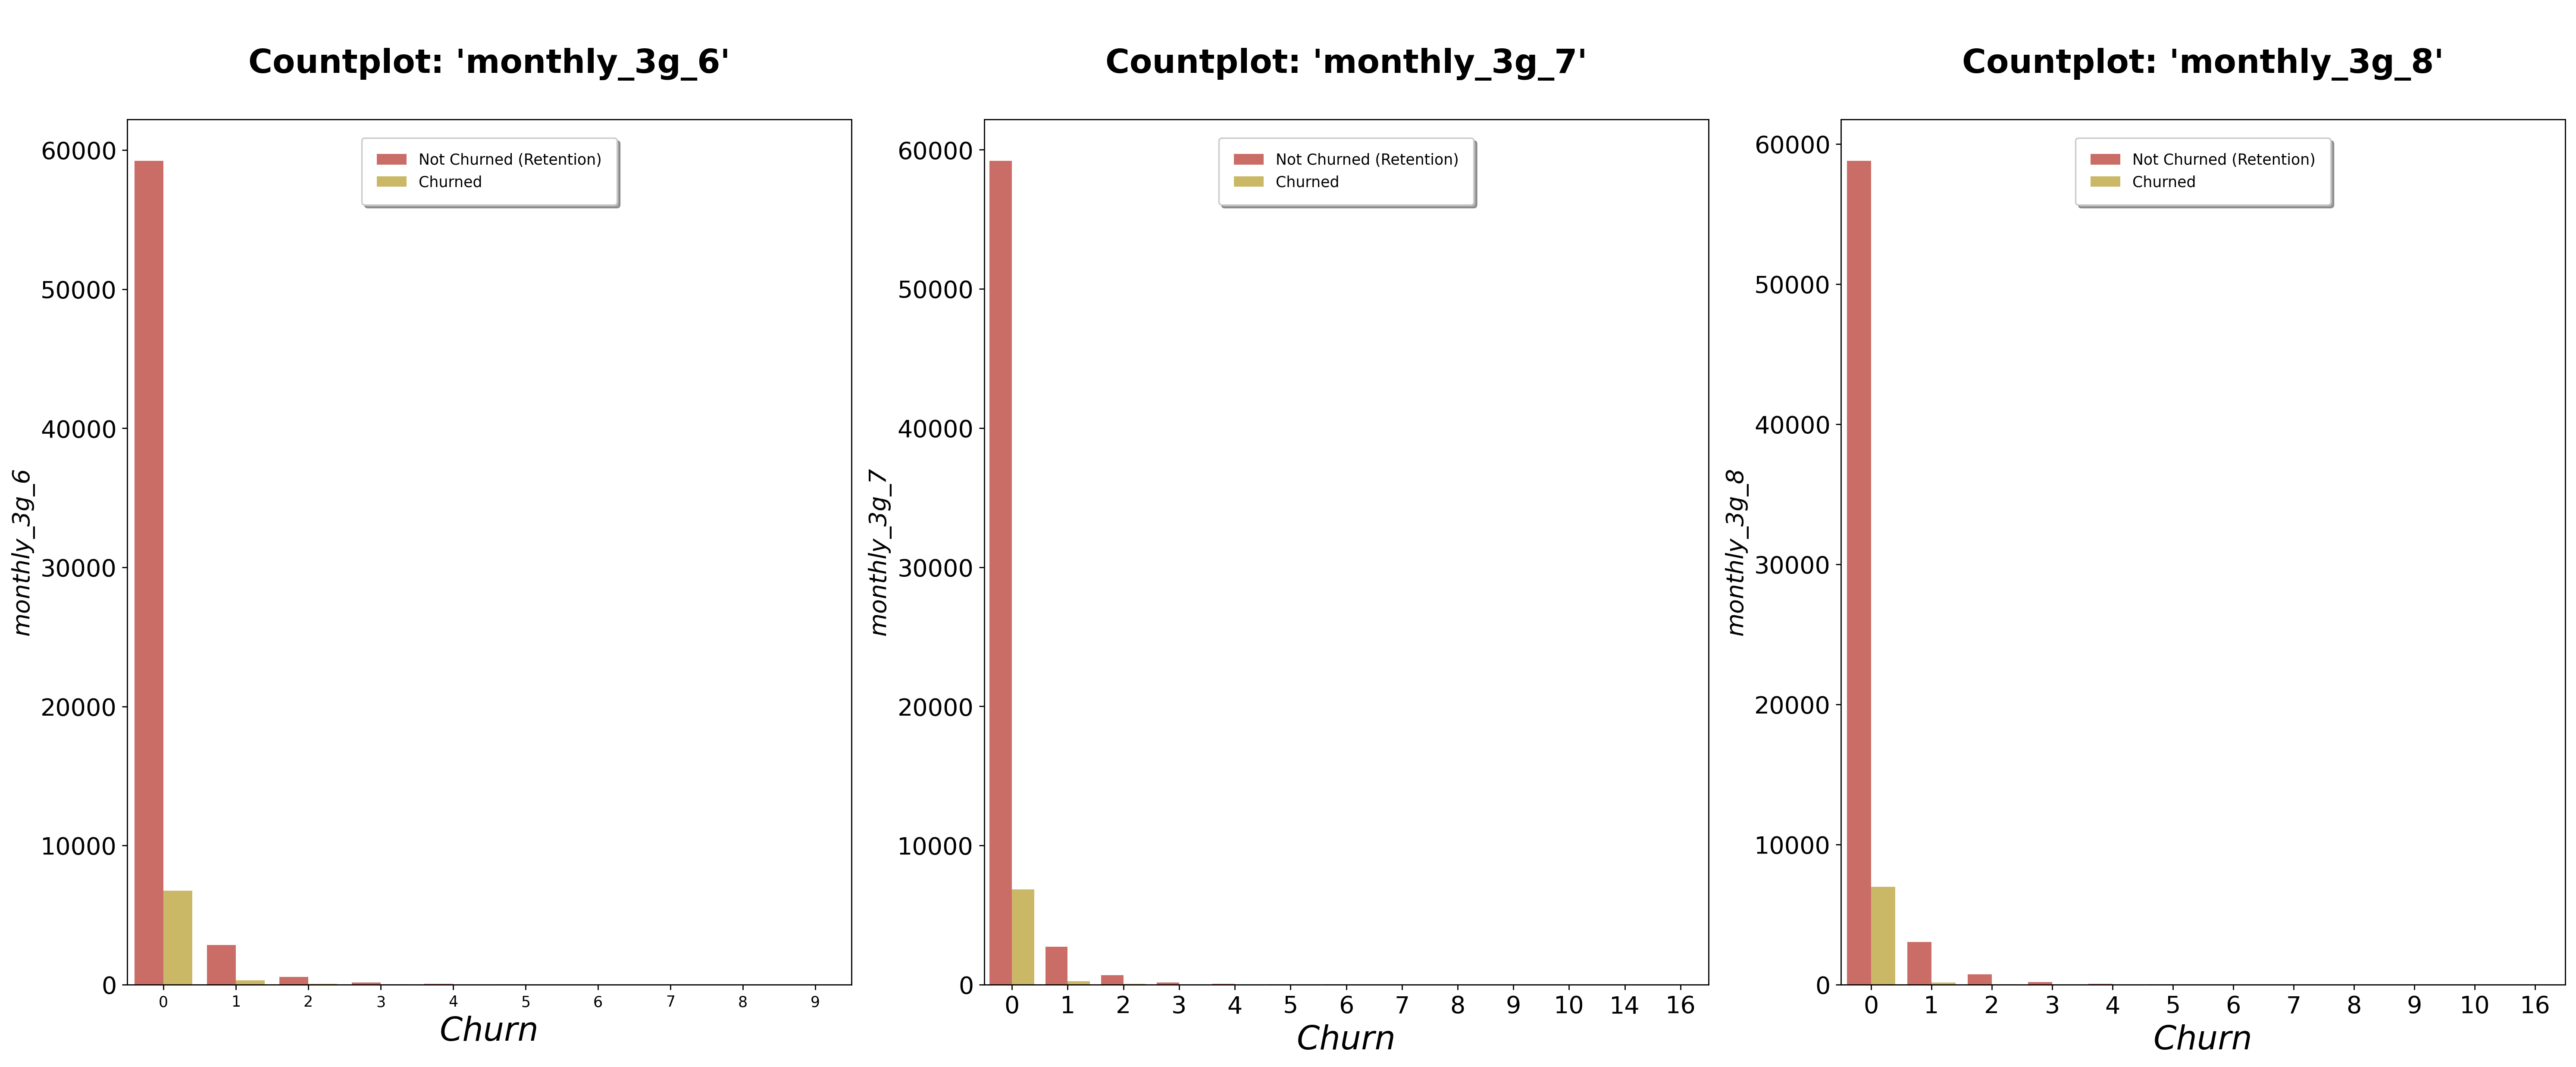

In [37]:
plot_countplots_6_7_8("monthly_3g")

#### General Observations

Distribution: The distribution of monthly_3g usage is heavily skewed towards the lower end for both churned and non-churned customers in all three months. This suggests that a significant portion of customers have low or no 3G usage.
Churn vs. Non-Churn

Usage: The majority of customers in all three months, regardless of churn status, fall into the lowest usage categories (0-2).
Churn Proportion: The proportion of churned customers within each usage category is generally lower than the proportion of non-churned customers. This suggests that customers with higher monthly_3g usage might be less likely to churn.
Month-to-Month Comparison

Usage Patterns: The overall usage patterns seem to be relatively consistent across the three months.
Churn Proportion: The proportion of churned customers within each usage category appears to remain fairly stable across the months.
Possible Interpretations

Usage and Churn: While the relationship might not be straightforward, higher monthly_3g usage could be associated with a lower churn risk.

In [39]:
data["sachet_total_6"] = data["sachet_3g_6"] + data["sachet_2g_6"]
data["sachet_total_7"] = data["sachet_3g_7"] + data["sachet_2g_7"]
data["sachet_total_8"] = data["sachet_3g_8"] + data["sachet_2g_8"]

In [40]:
# plot_countplots_6_7_8("vol_2g_mb")

In [41]:
# plot_countplots_6_7_8("vol_3g_mb")

In [42]:
# plot_countplots_6_7_8("sachet_total")

In [43]:
# ***********NOT NEEDED*************
# # arpu for 6th and 7th month
# average_revenue_cols = [i for i in data.columns if re.search("arpu",i)]
# average_revenue_cols
# null_prcnt_df(data[average_revenue_cols])
# data[average_revenue_cols].describe()
# data["arpu_6_new"] = data["arpu_3g_6"] + data["arpu_2g_6"]
# data["arpu_7_new"] = data["arpu_3g_7"] + data["arpu_2g_7"]
# data["arpu_8_new"] = data["arpu_3g_8"] + data["arpu_2g_8"]
# data[["arpu_8_new", "arpu_8", "arpu_7_new", "arpu_7", "arpu_6_new", "arpu_6"]].head()

# ***********NOT NEEDED*************
# data["local_incoming_6"] = data["loc_ic_t2t_mou_6"] + data["loc_ic_t2m_mou_6"] + data["loc_ic_t2f_mou_6"] + data["loc_ic_t2o_mou"]
# data["local_incoming_7"] = data["loc_ic_t2t_mou_7"] + data["loc_ic_t2m_mou_7"] + data["loc_ic_t2f_mou_7"] + data["loc_ic_t2o_mou"]
# data["local_incoming_8"] = data["loc_ic_t2t_mou_8"] + data["loc_ic_t2m_mou_8"] + data["loc_ic_t2f_mou_8"] + data["loc_ic_t2o_mou"]

# data["local_outgoing_6"] = data["loc_og_t2t_mou_6"] + data["loc_og_t2m_mou_6"] + data["loc_og_t2f_mou_6"] + data["loc_og_t2c_mou_6"] + data["loc_og_t2o_mou"]
# data["local_outgoing_7"] = data["loc_og_t2t_mou_7"] + data["loc_og_t2m_mou_7"] + data["loc_og_t2f_mou_7"] + data["loc_og_t2c_mou_7"] + data["loc_og_t2o_mou"]
# data["local_outgoing_8"] = data["loc_og_t2t_mou_8"] + data["loc_og_t2m_mou_8"] + data["loc_og_t2f_mou_8"] + data["loc_og_t2c_mou_8"] + data["loc_og_t2o_mou"]

# data["std_outgoing_6"] = data["std_og_t2t_mou_6"] + data["std_og_t2m_mou_6"] + data["std_og_t2f_mou_6"] + data["std_og_t2c_mou_6"] + data["std_og_t2o_mou"]
# data["std_outgoing_7"] = data["std_og_t2t_mou_7"] + data["std_og_t2m_mou_7"] + data["std_og_t2f_mou_7"] + data["std_og_t2c_mou_7"] + data["std_og_t2o_mou"]
# data["std_outgoing_8"] = data["std_og_t2t_mou_8"] + data["std_og_t2m_mou_8"] + data["std_og_t2f_mou_8"] + data["std_og_t2c_mou_8"] + data["std_og_t2o_mou"]

# data["std_incoming_6"] = data["std_ic_t2t_mou_6"] + data["std_ic_t2m_mou_6"] + data["std_ic_t2f_mou_6"] + data["std_ic_t2o_mou_6"]
# data["std_incoming_7"] = data["std_ic_t2t_mou_7"] + data["std_ic_t2m_mou_7"] + data["std_ic_t2f_mou_7"] + data["std_ic_t2o_mou_7"]
# data["std_incoming_8"] = data["std_ic_t2t_mou_8"] + data["std_ic_t2m_mou_8"] + data["std_ic_t2f_mou_8"] + data["std_ic_t2o_mou_8"]


In [44]:
# Removing columns that show constant variance (i.e. all values are constant or 0)
# def remove_SingleUniqueValue_column(df):
#     df_newsingle = df.copy()
#     uniq_svcol = df_newsingle.nunique() ==1
#     list_uniq_svcol = list(uniq_svcol[uniq_svcol.values== True].index)
#     df_newsingle.drop(list_uniq_svcol, axis=1, inplace=True)
#     print('Columns that are dropped are:\n{0}'.format(list_uniq_svcol))
#     print('\nNumber of columns dropped:\n{0}'.format(len(list_uniq_svcol)))
#     return df_newsingle

# data = remove_SingleUniqueValue_column(data)

In [45]:
# X = data.iloc[:,:-1]
# y = data.iloc[:,-1]

# print("========================================================================")
# print("X Dataset: ", X.shape) 
# print("y Dataset: ", y.shape) 
# print("========================================================================")

In [46]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print("========================================================================")
# print("X Train Dataset: ", X_train.shape) 
# print("X Test Dataset: ", X_test.shape) 
# print("y Train Dataset: ", y_train.shape) 
# print("y Test Dataset: ", y_test.shape) 
# print("========================================================================")

In [47]:
# print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
# print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# smote = SMOTE(random_state = 42)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train.ravel())

# print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
# print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

# print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
# print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

In [48]:
# columns = data.columns

# ids = ["id","circle_id"]
# total_amounts = [i for i in columns if re.search("total.+amt", i)]
# total_outgoing_minutes = [i for i in columns if re.search("total.+og.+mou",i)]
# total_incoming_minutes = [i for i in columns if re.search("total.+ic.+mou",i)]
# local_outgoing_minutes = [i for i in columns if re.search("loc.+og_mou",i)]
# local_incoming_minutes = [i for i in columns if re.search("loc.+ic_mou",i)]
# offnetwork_minutes = [i for i in columns if re.search("offnet",i)]
# onnetwork_minutes = [i for i in columns if re.search("onnet",i)]
# average_revenue = [i for i in columns if re.search("arpu",i)]
# volume_3g = [i for i in columns if re.search("vol.+3g",i)]
# volume_2g = [i for i in columns if re.search("vol.+2g",i)]
# age_on_network = [i for i in columns if re.search("aon",i)]
# dates = [i for i in columns if (re.search("date.+of.+last.+rech",i))]

# variables = [*ids, *total_amounts, *total_outgoing_minutes, *total_incoming_minutes,
#              *local_outgoing_minutes, *local_incoming_minutes, *offnetwork_minutes, 
#              *onnetwork_minutes, *average_revenue, *volume_3g, *volume_2g,
#              *age_on_network, *dates, "churn_probability"]

# data_cleaned = data[variables].set_index("id")
# data_cleaned.shape